# Скачиваем

In [2]:
import requests
from tqdm import tqdm
import os.path

def download_with_progress(url, destination):
    if os.path.exists(destination):
        print(f"File already exists at {destination}. Skipping download.")
        return
    response = requests.get(url, stream=True)
    response.raise_for_status()
    total = int(response.headers.get('content-length', 0))
    with open(destination, "wb") as f, tqdm(
        desc=destination,
        total=total,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for chunk in response.iter_content(chunk_size=32768):
            if chunk:
                f.write(chunk)
                bar.update(len(chunk))
    print(f"Downloaded to {destination}")

dataset_url = "https://dano.hse.ru/mirror/pubs/share/987942268.csv"
destination = "tb_scooter_trips.csv"
download_with_progress(dataset_url, destination)


File already exists at tb_scooter_trips.csv. Skipping download.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.copy_on_write = True

df = pd.read_csv(destination)

# Преобразуем

In [4]:
def conversion(data:pd.DataFrame) -> pd.DataFrame:
    

    data['created_dttm'] = pd.to_datetime(data['created_dttm'])
    data['book_start_dttm'] = pd.to_datetime(data['book_start_dttm'])
    data['book_end_dttm'] = pd.to_datetime(data['book_end_dttm'])
    data['local_book_start_dttm'] = pd.to_datetime(data['local_book_start_dttm'])

    data['gender_cd'] = data['gender_cd'].astype('category')
    data['education_level_cd'] = data['education_level_cd'].astype('category')
    data['marital_status_cd'] = data['marital_status_cd'].astype('category')
    data['lvn_state_nm'] = data['lvn_state_nm'].astype('category')
    data['transport_model'] = data['transport_model'].astype('category')

    data['price'] = data['nominal_price_rub_amt'] - data['loyalty_accrual_rub_amt'].fillna(0) - data['loyalty_accrual_bns_amt'].fillna(0)
    data['book_time_secs'] = (data['book_end_dttm'] - data['book_start_dttm']).dt.total_seconds()
    data['sum_bns'] = data['loyalty_accrual_rub_amt'].fillna(0) + data['loyalty_accrual_bns_amt'].fillna(0)
    data['order_count'] = data.groupby('party_rk')['order_rk'].transform('count')

    return data

df = conversion(df)
df.drop(columns=['order_rk', 'party_rk', 'created_dttm', 'book_start_dttm', 'book_end_dttm', 'book_time_zone_cd', 'local_book_start_dttm', 
                 'nominal_price_rub_amt', 'loyalty_accrual_rub_amt', 'loyalty_accrual_bns_amt']).describe()

,age,minute_cost,activation_cost,hold_amount,distance_km,price,book_time_secs,sum_bns,order_count
count,396749.000000,396749.000000,396749.000000,396749.000000,396749.000000,396749.000000,396749.000000,396749.000000,396749.000000
mean,31.544006,7.288688,42.593226,299.983869,3.681031,85.876105,686.459337,41.771589,36.547775
std,9.434545,1.289492,11.989974,1.939153,141.862349,133.622459,790.490068,139.090247,47.121033
min,12.000000,1.500000,0.000000,80.000000,0.000000,-52422.330970,2.004000,-161.940000,1.000000
25%,24.000000,6.490000,30.000000,300.000000,0.941054,54.520000,285.783419,11.010000,6.000000
50%,31.000000,7.490000,50.000000,300.000000,1.729883,77.960000,466.119018,19.090000,19.000000
75%,37.000000,8.220000,50.000000,300.000000,3.063694,107.890000,802.262417,38.760000,49.000000
max,94.000000,19.990000,50.000000,500.000000,56012.640308,5555.610000,42910.332373,55429.360970,388.000000


# Исследуем

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396749 entries, 0 to 396748
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   order_rk                 396749 non-null  int64         
 1   party_rk                 396749 non-null  int64         
 2   gender_cd                393828 non-null  category      
 3   age                      396749 non-null  int64         
 4   education_level_cd       190059 non-null  category      
 5   marital_status_cd        217729 non-null  category      
 6   lvn_state_nm             362572 non-null  category      
 7   minute_cost              396749 non-null  float64       
 8   activation_cost          396749 non-null  float64       
 9   hold_amount              396749 non-null  float64       
 10  transport_model          396749 non-null  category      
 11  distance_km              396749 non-null  float64       
 12  created_dttm    

In [6]:
df.describe()

,order_rk,party_rk,age,minute_cost,activation_cost,hold_amount,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt,price,book_time_secs,sum_bns,order_count
count,3.967490e+05,3.967490e+05,396749.000000,396749.000000,396749.000000,396749.000000,396749.000000,396749,396749,396749,396749.000000,396749,396749.000000,366992.000000,21948.000000,396749.000000,396749.000000,396749.000000,396749.000000
mean,2.892236e+08,5.988426e+08,31.544006,7.288688,42.593226,299.983869,3.681031,2024-08-18 19:57:21.649821952,2024-08-18 19:57:27.763654912,2024-08-18 20:08:54.222992128,3.536155,2024-08-18 20:29:37.922017280,127.647694,37.516121,127.789319,85.876105,686.459337,41.771589,36.547775
min,2.526112e+08,1.471700e+04,12.000000,1.500000,0.000000,80.000000,0.000000,2024-04-07 14:56:47,2024-04-07 14:57:01.030814,2024-04-07 15:00:26.432310,0.000000,2024-04-07 14:57:01.030814,0.000000,-161.940000,1.000000,-52422.330970,2.004000,-161.940000,1.000000
25%,2.618150e+08,2.962323e+08,24.000000,6.490000,30.000000,300.000000,0.941054,2024-07-22 05:09:57,2024-07-22 05:10:01.884925952,2024-07-22 05:19:02.033711104,3.000000,2024-07-22 05:36:05.428699904,80.840000,11.240000,43.000000,54.520000,285.783419,11.010000,6.000000
50%,2.704367e+08,6.110092e+08,31.000000,7.490000,50.000000,300.000000,1.729883,2024-08-23 10:44:44,2024-08-23 10:44:48.782873088,2024-08-23 10:56:03.260775936,3.000000,2024-08-23 11:26:34.415717120,103.940000,18.730000,62.000000,77.960000,466.119018,19.090000,19.000000
75%,3.432678e+08,8.646921e+08,37.000000,8.220000,50.000000,300.000000,3.063694,2024-09-16 14:00:40,2024-09-16 14:00:44.200000,2024-09-16 14:13:01.654374912,3.000000,2024-09-16 14:33:59.144999936,142.100000,35.060000,81.000000,107.890000,802.262417,38.760000,49.000000
max,3.562528e+08,1.301075e+09,94.000000,19.990000,50.000000,500.000000,56012.640308,2024-10-21 17:18:04,2024-10-21 17:18:07.715000,2024-10-21 17:23:06.640943,12.000000,2024-10-21 21:13:43.199000,5627.640000,3185.000000,55429.360970,5555.610000,42910.332373,55429.360970,388.000000
std,3.813458e+07,3.311675e+08,9.434545,1.289492,11.989974,1.939153,141.862349,NaN,NaN,NaN,1.209075,NaN,100.122365,75.208560,496.812143,133.622459,790.490068,139.090247,47.121033


Ну что тут можно сказать:

- *age*: Кто то катается в 12, а кто то в 94. Средний возраст - 31 год, что довольно таки странно, я думал это интересно студентам, но нет.
- *distance_km*: Ксть сумашедший, который проехал земной шар на самокате вокруг (надо на него посмотреть)
- *price*: Отрицательная цена это интересно, ему еще и заплатили. Тоже так хочу!

In [7]:
df.sort_values(by='distance_km').tail(5)

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,...,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt,price,book_time_secs,sum_bns,order_count
385466,266073524,70699616,M,46,GRD,MAR,Г МОСКВА,8.49,50.0,300.0,...,2024-08-07 14:29:19.592234,3,2024-08-07 13:38:29.075803,482.99,72.30,NaN,410.69,3050.516431,72.30,5
300080,355425512,865803190,M,31,NaN,NaN,NaN,8.49,50.0,300.0,...,2024-10-18 13:03:44.795520,3,2024-10-18 12:38:57.624000,262.25,48.90,NaN,213.35,1487.171520,48.90,115
313313,274439844,58660326,M,34,GRD,MAR,МОСКОВСКАЯ ОБЛ,6.53,50.0,300.0,...,2024-09-06 07:26:38.857011,3,2024-09-06 07:23:54.260000,69.59,13.92,NaN,55.67,164.597011,13.92,19
175173,261054571,293397690,M,30,UGR,UNM,РЕСП МОРДОВИЯ,8.49,30.0,300.0,...,2024-07-19 13:14:31.402906,3,2024-07-19 13:11:31.981187,55.47,7.55,NaN,47.92,179.421719,7.55,3
11244,252634726,695658540,M,23,SCH,UNM,ЯРОСЛАВСКАЯ ОБЛ,4.99,30.0,300.0,...,2024-06-09 00:17:38.340000,3,2024-06-09 00:01:38.297341,109.84,10.98,NaN,98.86,960.042659,10.98,11


Видимо датчики борахлят... А скольно таких? Пусть нормальный человек не ездиет более 100км(да и аккума не хватит).

In [8]:
df[df['distance_km'] > 100].shape[0]

262

А что за модель?

<Axes: xlabel='transport_model', ylabel='distance_km'>

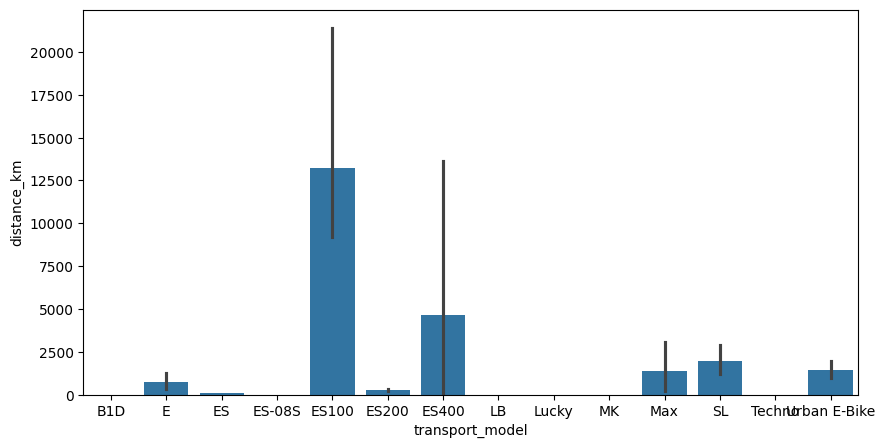

In [9]:
plt.figure(figsize=(10, 5))
sns.barplot(df[df['distance_km'] > 100], x='transport_model', y='distance_km')

In [10]:
df = df[(df['distance_km'] < 100)]

ES*** в основном. Ладно, удалим эти данные. А что с заработком на самокатах?

In [11]:
df[df['price'] < 0]

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,...,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt,price,book_time_secs,sum_bns,order_count
19,254950728,600634823,M,31,NaN,NaN,НИЖЕГОРОДСКАЯ ОБЛ,4.99,40.0,300.0,...,2024-06-26 04:27:46.509259,3,2024-06-26 04:15:08.953368,104.87,NaN,819.86830,-714.99830,757.555891,819.86830,20
76,350559020,1524358,M,50,GRD,UNM,МОСКОВСКАЯ ОБЛ,8.03,50.0,300.0,...,2024-09-30 12:34:27.190433,3,2024-09-30 12:25:54.302000,122.27,124.27,NaN,-2.00000,512.888433,124.27000,2
177,348830319,1005067430,M,36,NaN,NaN,Г МОСКВА,7.99,50.0,300.0,...,2024-09-24 13:53:25.418862,3,2024-09-24 13:38:45.224000,169.85,171.85,NaN,-2.00000,880.194862,171.85000,1
224,346863032,273320433,M,47,UGR,UNM,Г МОСКВА,7.99,50.0,300.0,...,2024-09-17 13:35:24.326901,3,2024-09-17 13:27:18.121000,121.91,NaN,319.54334,-197.63334,486.205901,319.54334,38
375,256047325,1166686191,M,31,NaN,NaN,ПРИМОРСКИЙ КРАЙ,7.49,50.0,300.0,...,2024-06-30 13:18:24.855888,10,2024-06-30 20:10:57.301009,109.92,NaN,352.74996,-242.82996,447.554879,352.74996,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396576,277400001,665842150,M,39,NaN,NaN,Г МОСКВА,9.47,50.0,300.0,...,2024-09-10 10:57:05.773224,3,2024-09-10 10:45:48.997000,163.88,NaN,164.00000,-0.12000,676.776224,164.00000,1
396638,269620792,1070837113,M,18,NaN,NaN,NaN,4.99,50.0,300.0,...,2024-08-20 18:25:00.479344,5,2024-08-20 20:12:34.672952,114.87,132.10,NaN,-17.23000,745.806392,132.10000,1
396670,348288294,609388856,F,19,NaN,NaN,УЛЬЯНОВСКАЯ ОБЛ,7.49,30.0,300.0,...,2024-09-22 14:31:51.521149,3,2024-09-22 14:20:52.745000,112.39,114.39,NaN,-2.00000,658.776149,114.39000,1
396717,347423779,869968010,M,33,NaN,NaN,NaN,7.49,50.0,300.0,...,2024-09-19 15:48:33.113915,2,2024-09-19 14:32:46.323000,169.84,171.84,NaN,-2.00000,946.790915,171.84000,1


Я смотрю таких много.

In [12]:
df.sort_values(by='price').tail(5)

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,...,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt,price,book_time_secs,sum_bns,order_count
340555,261319091,943073656,M,30,SCH,UNM,Г МОСКВА,8.39,50.0,300.0,...,2024-07-20 17:11:41.426445,3,2024-07-20 13:36:16.909581,1862.24,-161.94,NaN,2024.18,12924.516864,-161.94,5
196855,273795885,354812734,M,25,NaN,UNM,РЕСП ТАТАРСТАН,6.99,30.0,300.0,...,2024-09-04 17:21:55.448589,3,2024-09-04 11:53:00.292957,2329.71,232.98,NaN,2096.73,19735.155632,232.98,12
249870,252625834,521589872,M,43,NaN,NaN,Г МОСКВА,8.99,50.0,300.0,...,2024-05-18 16:50:24.791943,3,2024-05-18 12:02:23.589902,2639.12,278.57,NaN,2360.55,17281.202041,278.57,3
64219,263092211,1168699602,M,56,NaN,NaN,МОСКОВСКАЯ ОБЛ,6.99,50.0,300.0,...,2024-07-27 15:05:30.449000,3,2024-07-27 04:48:33.276253,4362.83,654.31,NaN,3708.52,37017.172747,654.31,24
333308,258915624,522458259,F,37,UGR,MAR,РЕСП БУРЯТИЯ,7.79,50.0,300.0,...,2024-07-11 09:58:04.415000,8,2024-07-11 03:02:54.082627,5627.64,72.03,NaN,5555.61,42910.332373,72.03,3


Вон там бедолага забыл аренду занончить.

In [13]:
df.sort_values(by='price').head(5)

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,...,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt,price,book_time_secs,sum_bns,order_count
137393,347727529,589416418,M,34,UGR,UNM,СВЕРДЛОВСКАЯ ОБЛ,5.99,30.0,300.0,...,2024-09-20 15:47:18.289388,5,2024-09-20 09:30:26.390000,3007.03,NaN,55429.36097,-52422.33097,29811.899388,55429.36097,1
235128,269886066,687240520,M,26,SCH,CIV,ИРКУТСКАЯ ОБЛ,8.49,30.0,300.0,...,2024-08-21 05:11:01.749310,8,2024-08-21 07:19:20.112453,1490.28,NaN,24483.68130,-22993.40130,10301.636857,24483.68130,12
39868,269077105,1099015016,M,22,NaN,NaN,ПСКОВСКАЯ ОБЛ,8.99,30.0,300.0,...,2024-08-18 12:48:48.941261,3,2024-08-18 11:36:55.999633,677.28,NaN,12777.77787,-12100.49787,4312.941628,12777.77787,1
75179,273527252,428031611,F,20,NaN,NaN,ИРКУТСКАЯ ОБЛ,8.99,50.0,300.0,...,2024-09-03 20:29:15.831266,3,2024-09-03 19:29:14.405731,589.40,NaN,9480.68341,-8891.28341,3601.425535,9480.68341,4
115424,268194777,519640166,M,42,SCH,MAR,РЕСП БАШКОРТОСТАН,9.14,50.0,300.0,...,2024-08-15 08:47:00.466162,3,2024-08-15 08:02:46.479217,461.30,NaN,8380.95244,-7919.65244,2653.986945,8380.95244,2


А эти гении на банке зарабатвают. Мало информации что это за бонусы... Округлю все до 0.

In [14]:
df.loc[:, 'price'] = df['price'].clip(lower=0)

In [15]:
df.describe()

,order_rk,party_rk,age,minute_cost,activation_cost,hold_amount,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt,price,book_time_secs,sum_bns,order_count
count,3.964870e+05,3.964870e+05,396487.000000,396487.000000,396487.000000,396487.000000,396487.000000,396487,396487,396487,396487.000000,396487,396487.000000,366747.000000,21939.000000,396487.000000,396487.000000,396487.000000,396487.000000
mean,2.892286e+08,5.987938e+08,31.542895,7.288527,42.592027,299.983858,2.499602,2024-08-18 20:07:49.623148288,2024-08-18 20:07:55.736834048,2024-08-18 20:19:21.707771392,3.536308,2024-08-18 20:40:06.444272128,127.584793,37.485204,127.772289,89.065127,685.970937,41.743568,36.553693
min,2.526112e+08,1.471700e+04,12.000000,1.500000,0.000000,80.000000,0.000000,2024-04-09 12:23:51,2024-04-09 12:23:56.253700,2024-04-09 12:25:18.952234,0.000000,2024-04-09 12:23:56.253700,0.000000,-161.940000,1.000000,0.000000,2.004000,-161.940000,1.000000
25%,2.618150e+08,2.962323e+08,24.000000,6.490000,30.000000,300.000000,0.940645,2024-07-22 05:21:16.500000,2024-07-22 05:21:20.567860992,2024-07-22 05:27:09.889231616,3.000000,2024-07-22 05:42:50.340890880,80.790000,11.240000,43.000000,54.520000,285.740952,11.010000,6.000000
50%,2.704367e+08,6.110066e+08,31.000000,7.490000,50.000000,300.000000,1.728507,2024-08-23 10:48:08,2024-08-23 10:48:11.154274048,2024-08-23 10:59:12.900706048,3.000000,2024-08-23 11:28:35.420072960,103.940000,18.730000,62.000000,77.960000,466.022079,19.090000,19.000000
75%,3.432678e+08,8.646755e+08,37.000000,8.220000,50.000000,300.000000,3.059383,2024-09-16 14:02:42,2024-09-16 14:02:45.549500160,2024-09-16 14:15:25.048667392,3.000000,2024-09-16 14:36:11.483500032,141.915000,35.050000,81.000000,107.880000,801.904106,38.730000,49.000000
max,3.562528e+08,1.301075e+09,94.000000,19.990000,50.000000,500.000000,98.683568,2024-10-21 17:18:04,2024-10-21 17:18:07.715000,2024-10-21 17:23:06.640943,12.000000,2024-10-21 21:13:43.199000,5627.640000,3185.000000,55429.360970,5555.610000,42910.332373,55429.360970,388.000000
std,3.813602e+07,3.311516e+08,9.434100,1.289554,11.990549,1.939793,3.206039,NaN,NaN,NaN,1.209174,NaN,99.944624,75.009334,496.897934,72.558663,788.990320,139.020447,47.126880


# Визуализация

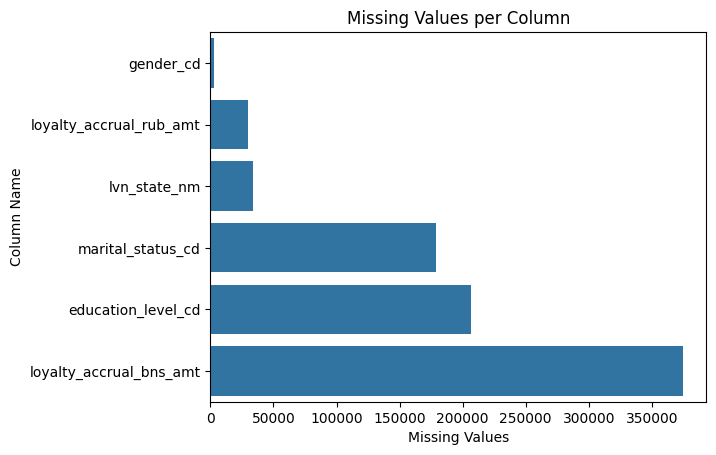

In [16]:
# Compute missing values
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values()

# Create dataframe for plotting
missing_df = missing.reset_index()
missing_df.columns = ['column', 'missing_count']

# Plot with switched axes (horizontal bars)
sns.barplot(x='missing_count', y='column', data=missing_df)
plt.xlabel('Missing Values')
plt.ylabel('Column Name')
plt.title('Missing Values per Column')
plt.show()

Все таки не про всех известен статус, приятная конфиденциальность. Только не видно колонки кто, что ел на утро...

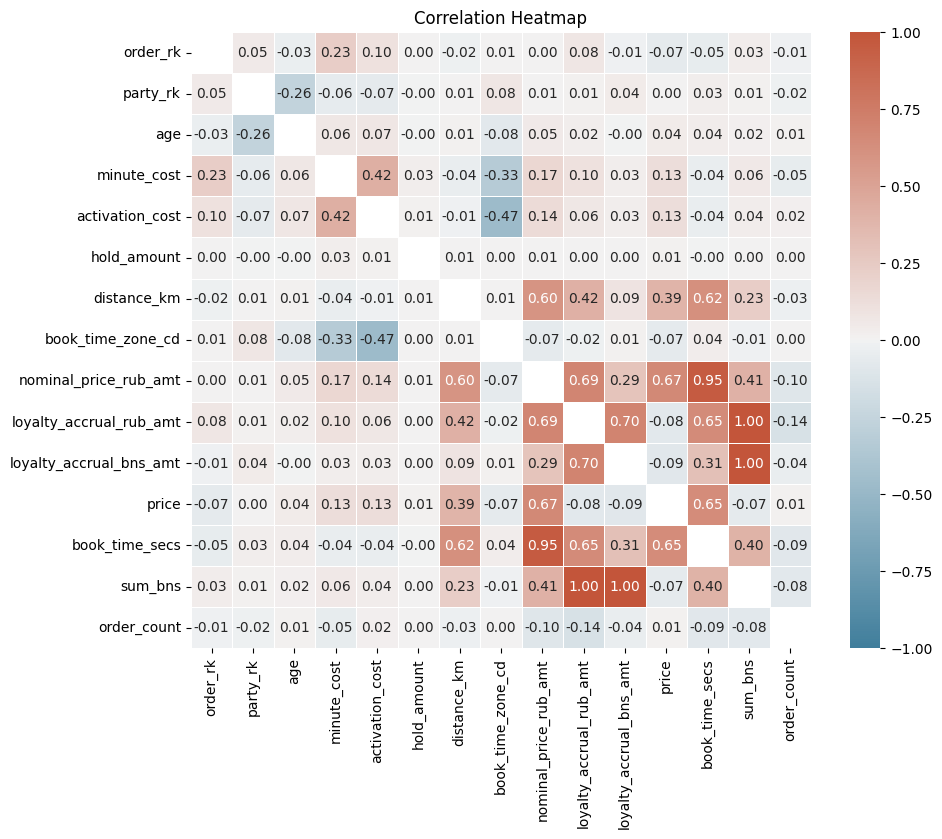

In [17]:
ndf = df.select_dtypes(include='number')
corr = ndf.corr()
mask = np.eye(corr.shape[0], dtype=bool)
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, vmin=-1, vmax=1, linewidths=0.5, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


/tmp/ipykernel_1573501/3196755808.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels(ordered_columns)


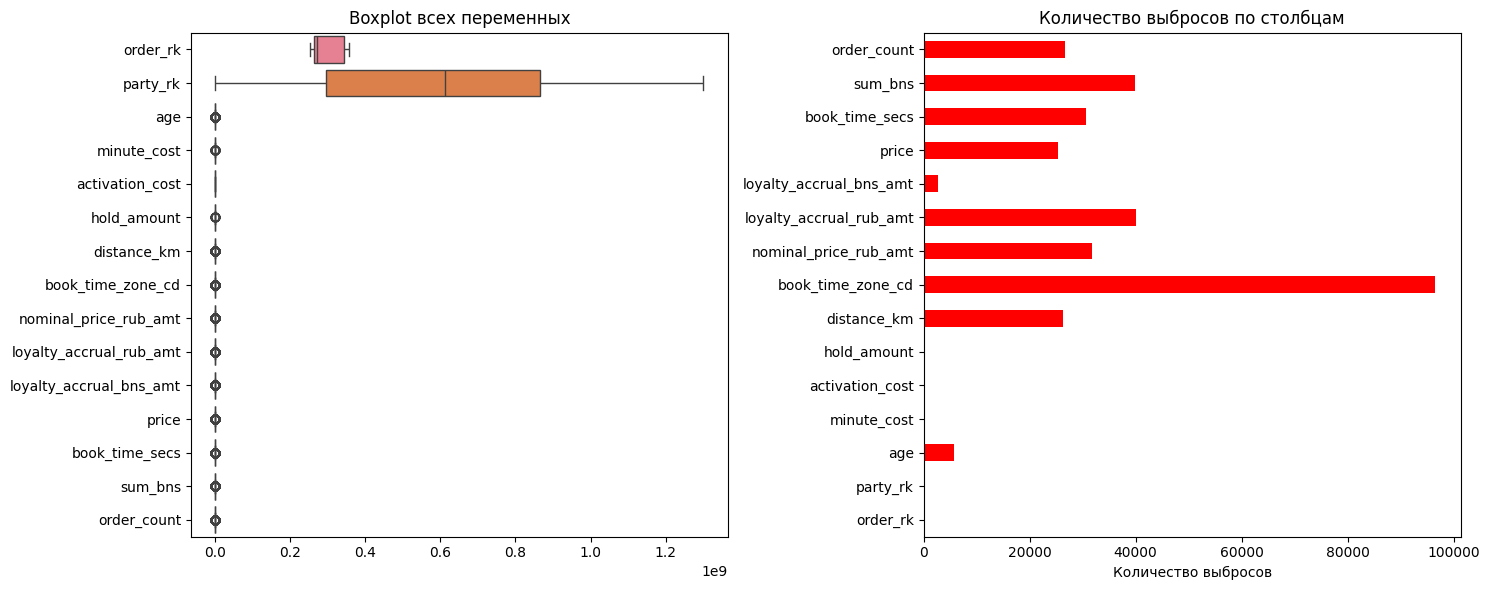

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ваш расчет выбросов (оставляем без изменений)
outlier_summary = {}
numeric_columns = df.select_dtypes(include=['number']).columns

for column in numeric_columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_count = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
    outlier_summary[column] = outliers_count

# Определяем порядок столбцов (это будет тот, что в df[numeric_columns])
ordered_columns = list(numeric_columns)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Boxplot для всех переменных, с заданным порядком
sns.boxplot(data=df[ordered_columns], orient='h', ax=axes[0])
axes[0].set_title('Boxplot всех переменных')
axes[0].set_yticklabels(ordered_columns)

# Гистограмма: количество выбросов по столбцам в том же порядке
outlier_counts_ordered = [outlier_summary[col] for col in ordered_columns]
pd.Series(outlier_counts_ordered, index=ordered_columns).plot(kind='barh', ax=axes[1], color='red')
axes[1].set_title('Количество выбросов по столбцам')
axes[1].set_xlabel('Количество выбросов')
axes[1].set_yticklabels(ordered_columns)

plt.tight_layout()
plt.show()


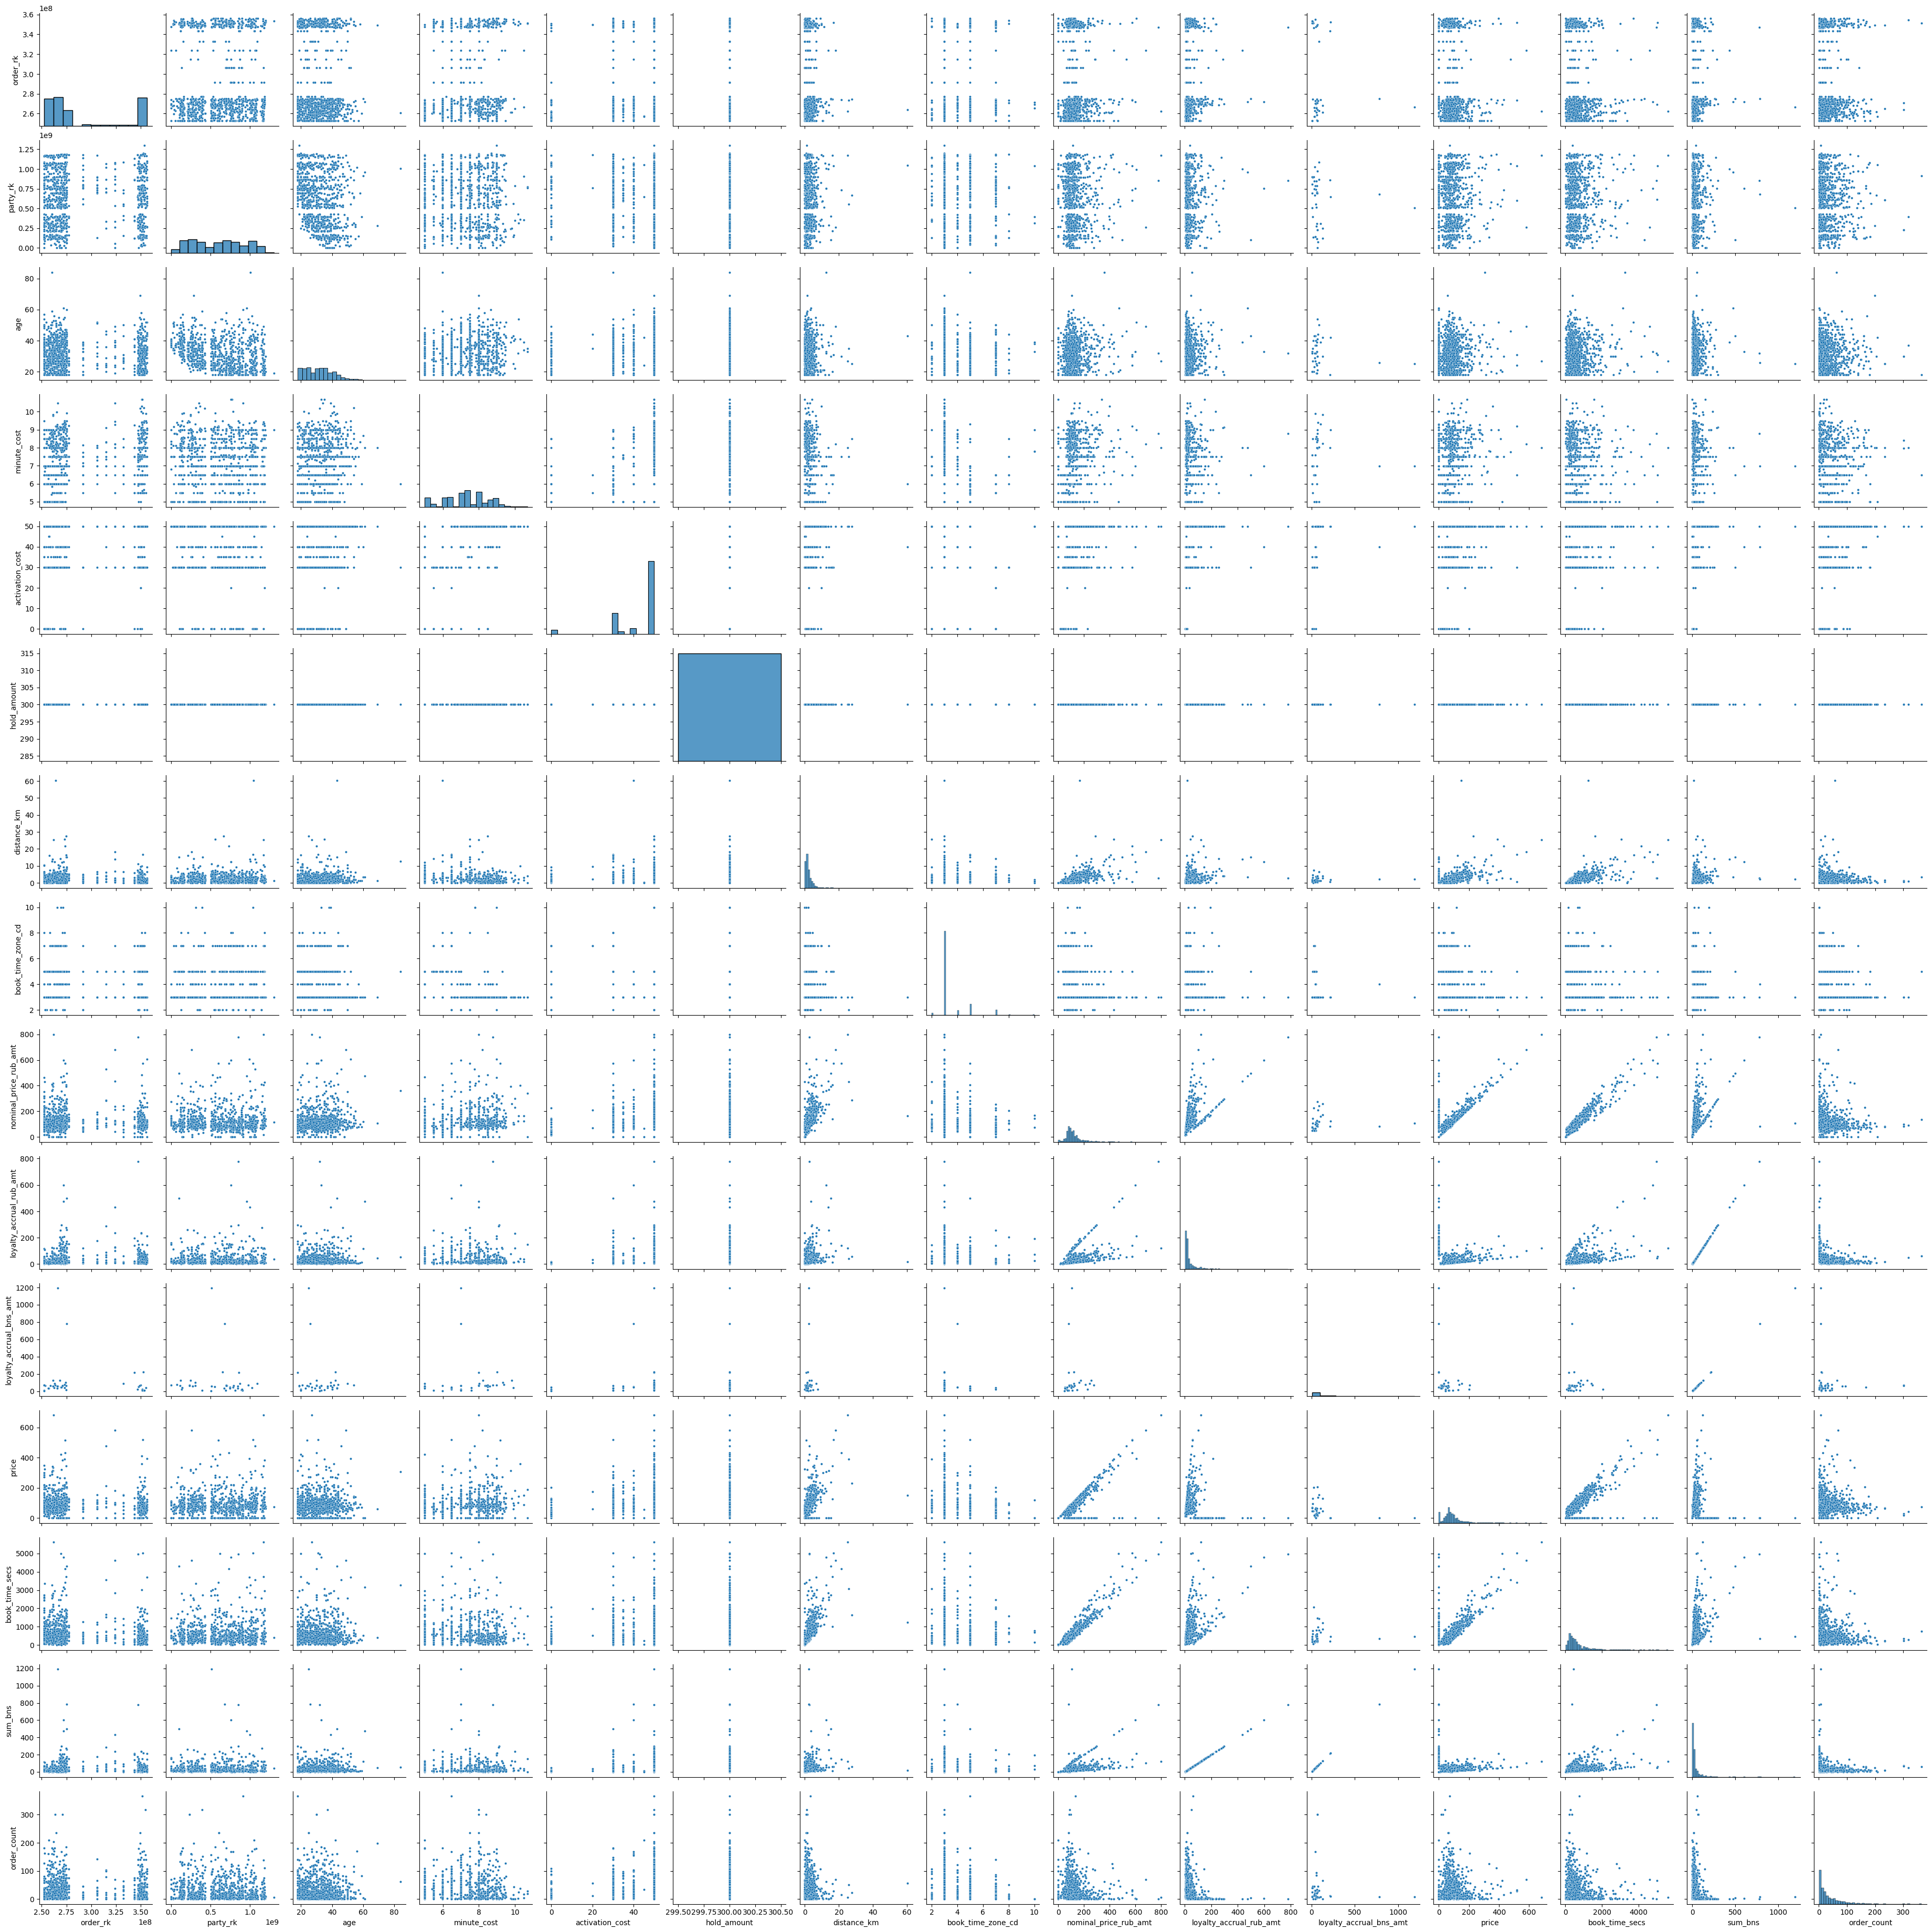

In [19]:
sns.pairplot(df.sample(1000), plot_kws={'s': 10})

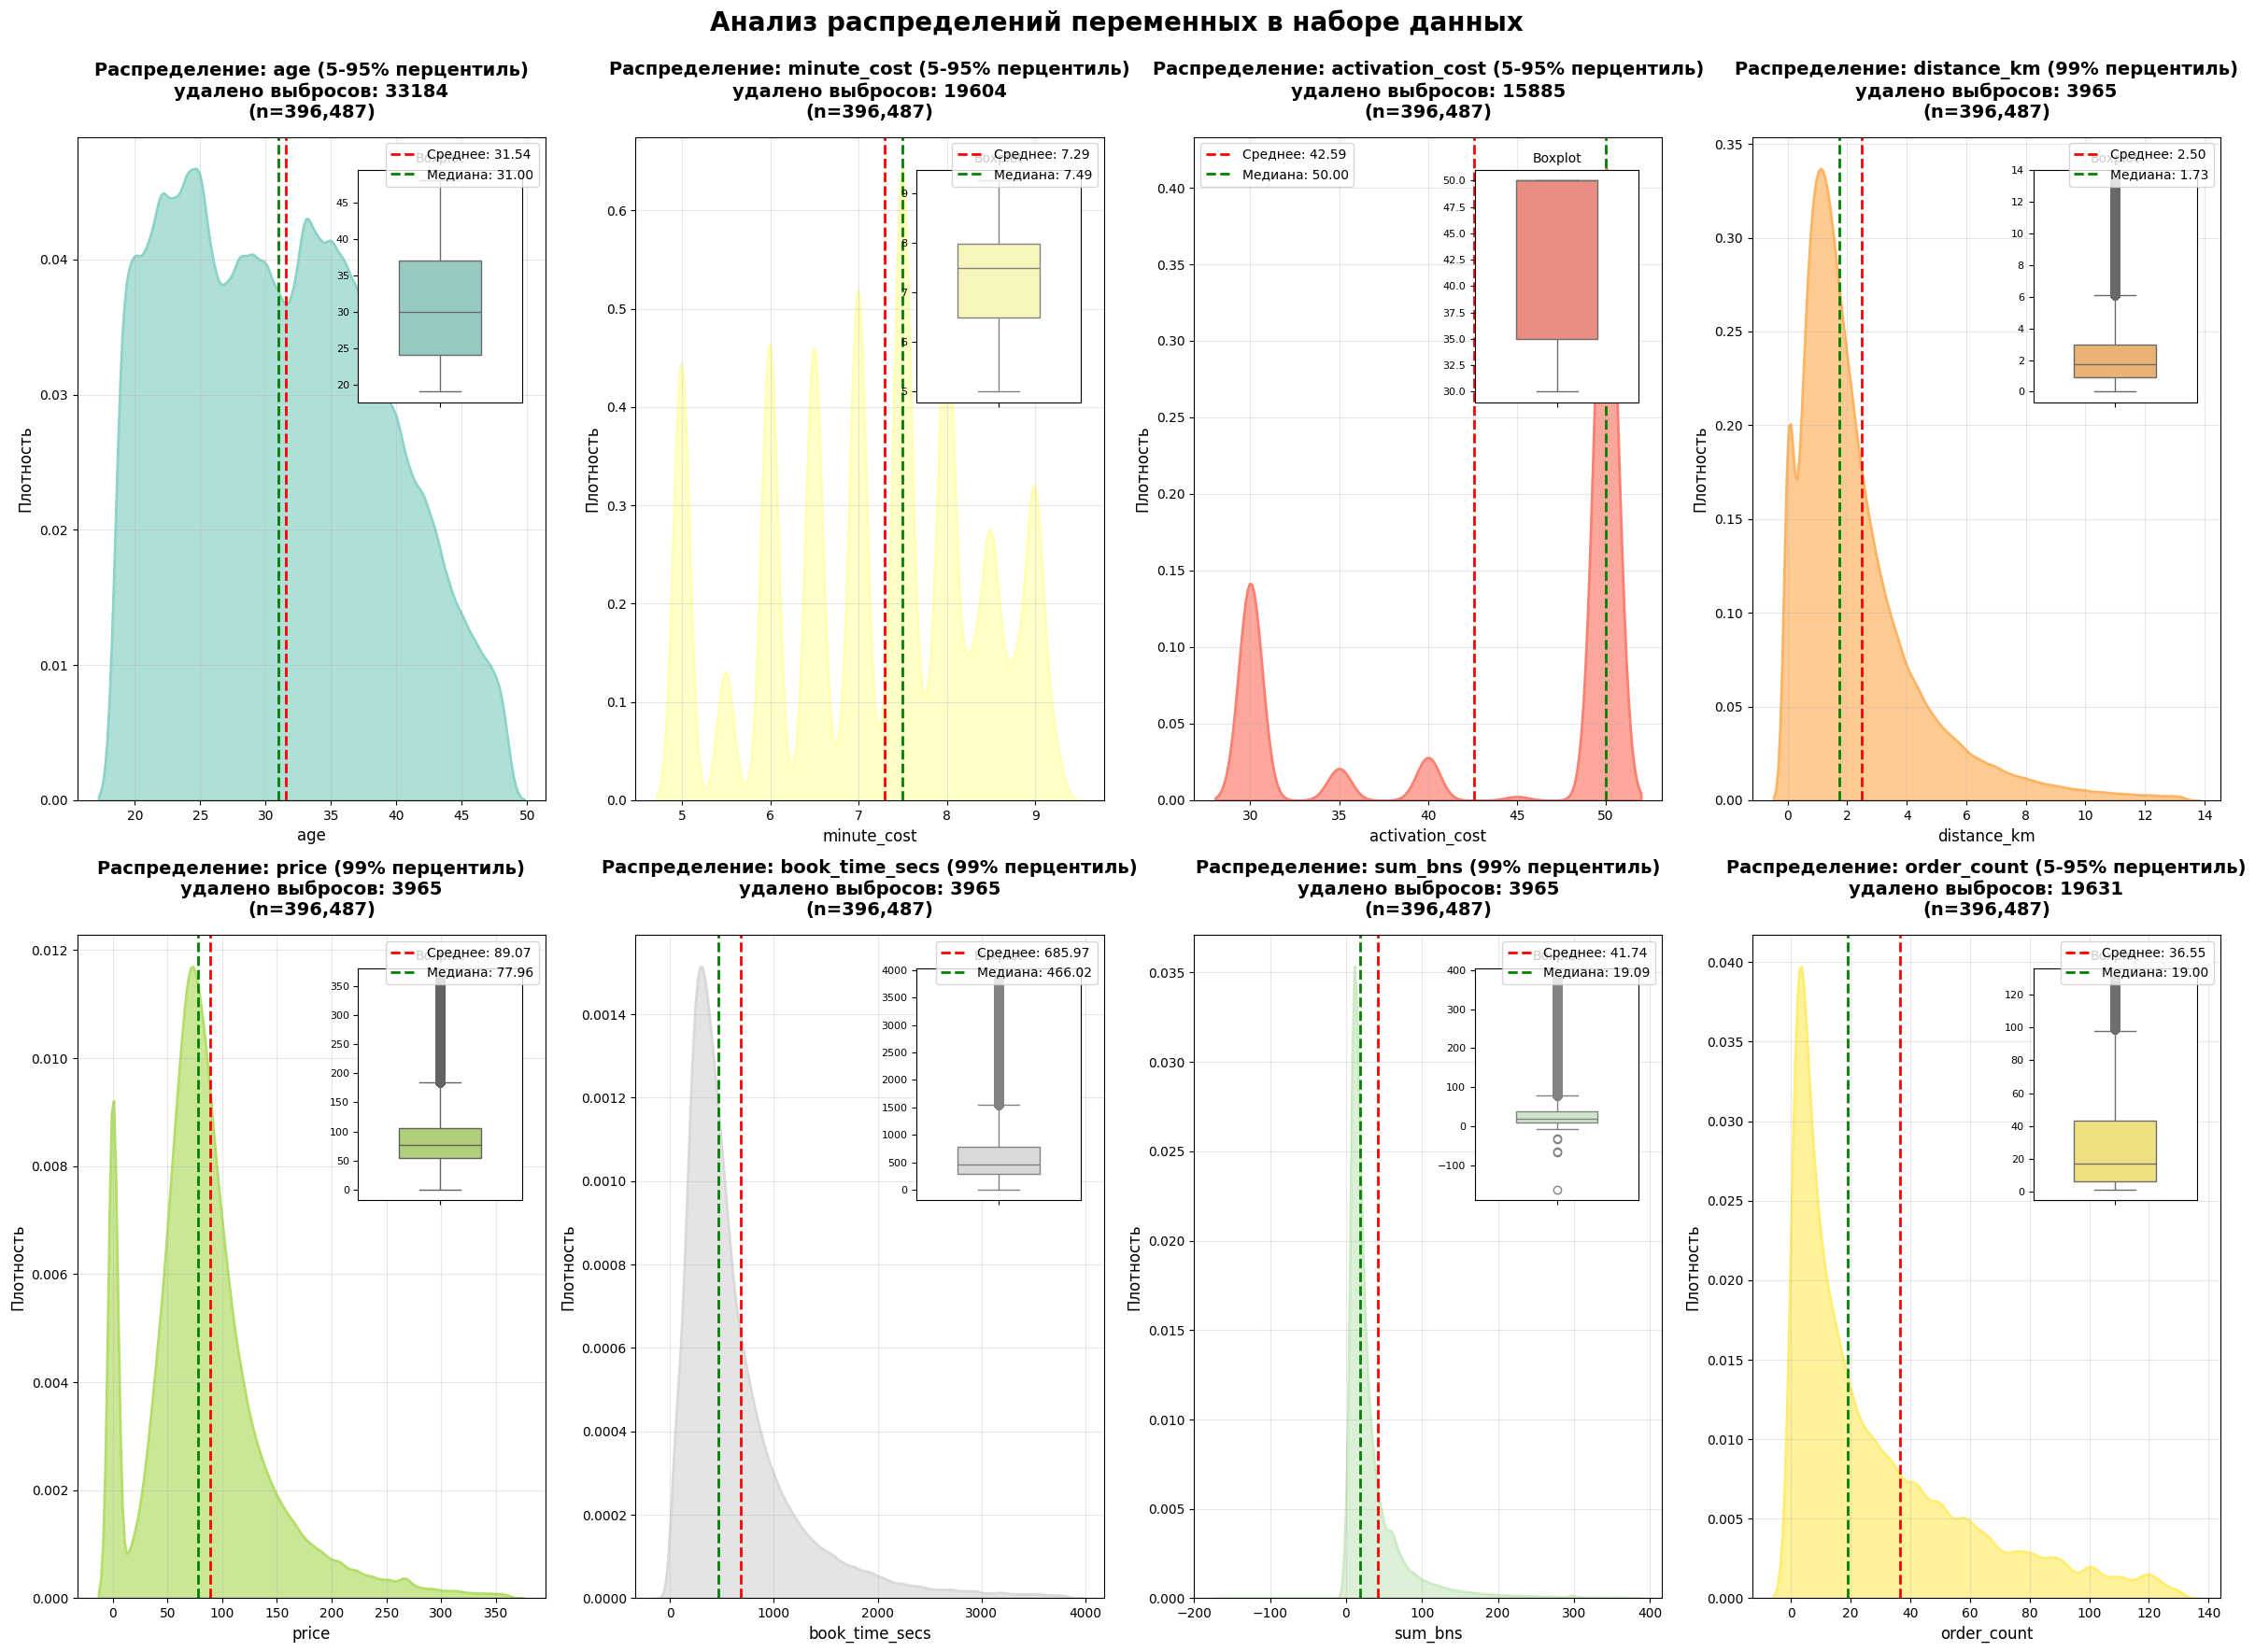

📊 СТАТИСТИЧЕСКИЕ ХАРАКТЕРИСТИКИ РАСПРЕДЕЛЕНИЙ
age                  | Асимметрия:   0.864 | Эксцесс:   1.243 | правостороннее, островершинное
minute_cost          | Асимметрия:  -0.056 | Эксцесс:  -0.235 | симметричное, нормальный эксцесс
activation_cost      | Асимметрия:  -1.832 | Эксцесс:   3.452 | левостороннее, островершинное
distance_km          | Асимметрия:   8.287 | Эксцесс: 139.727 | правостороннее, островершинное
price                | Асимметрия:   4.937 | Эксцесс: 129.229 | правостороннее, островершинное
book_time_secs       | Асимметрия:   6.475 | Эксцесс: 109.242 | правостороннее, островершинное
sum_bns              | Асимметрия: 181.021 | Эксцесс: 66305.800 | правостороннее, островершинное
order_count          | Асимметрия:   2.772 | Эксцесс:  11.194 | правостороннее, островершинное


🔍 ДЕТАЛЬНЫЙ АНАЛИЗ КЛЮЧЕВЫХ МЕТРИК


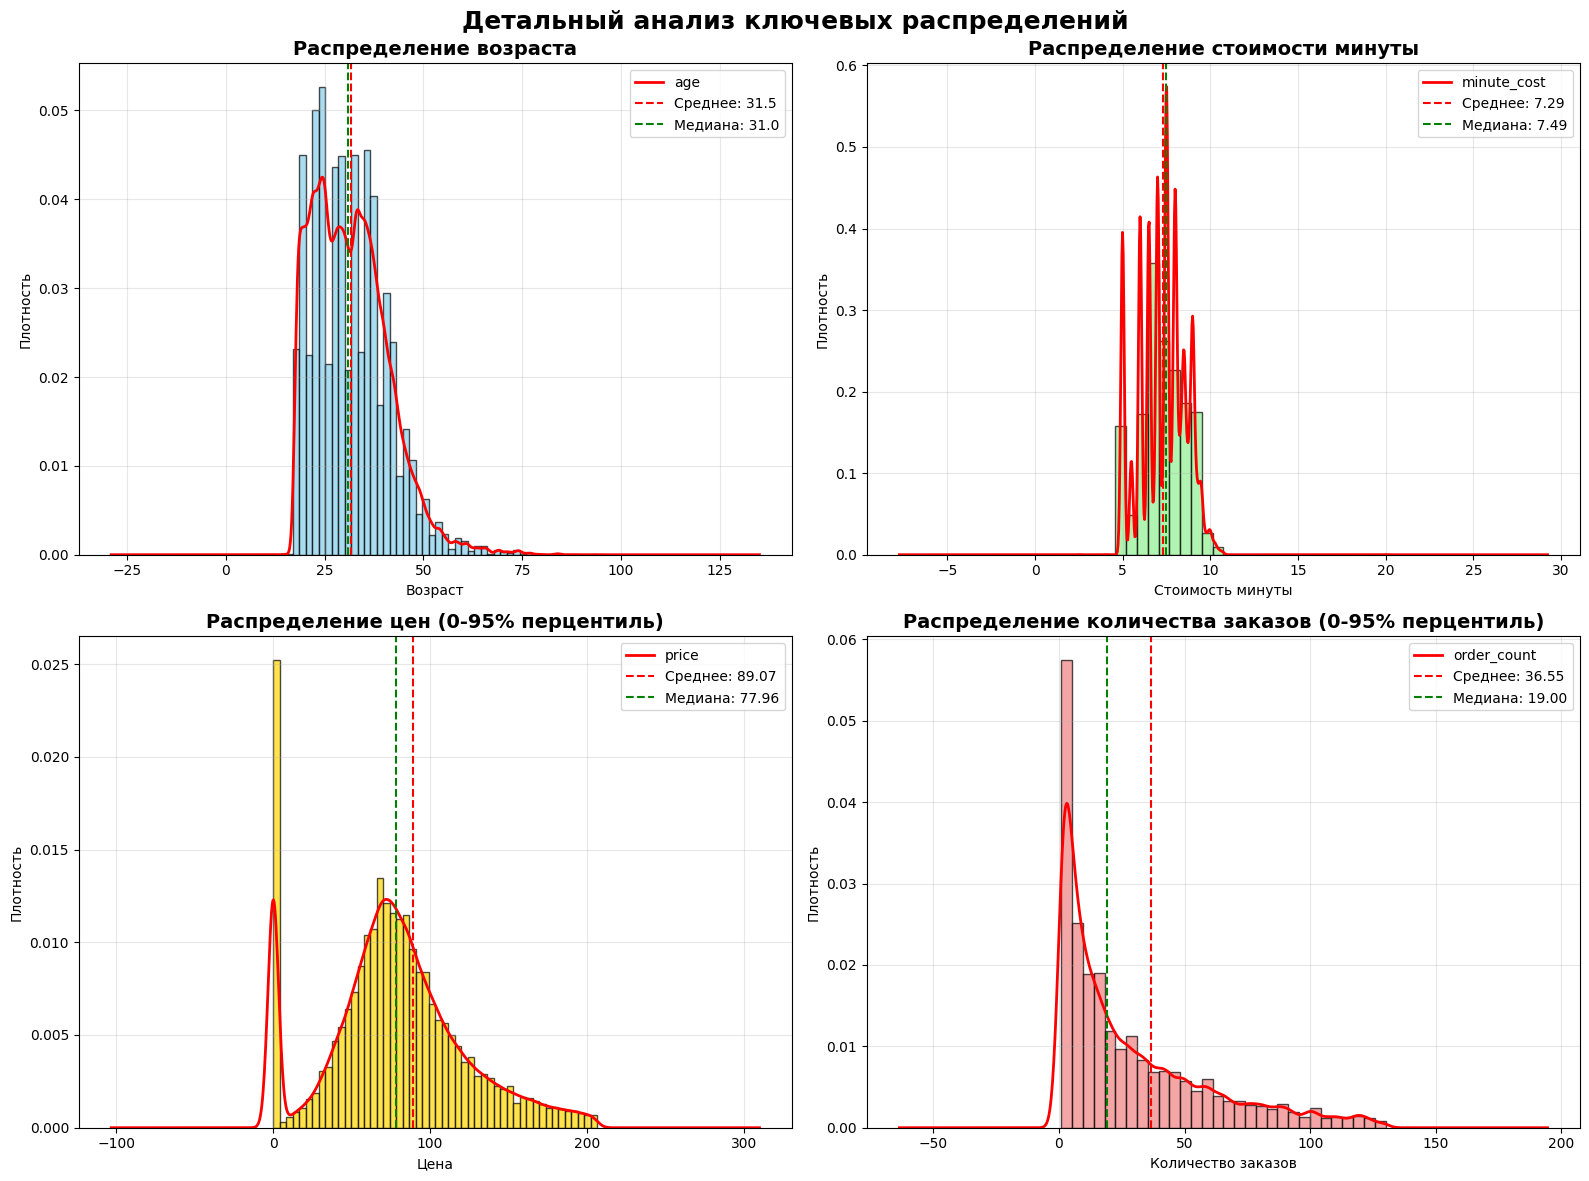


💡 КЛЮЧЕВЫЕ ИНСАЙТЫ ИЗ ДАННЫХ
✅ Возраст пользователей: нормальное распределение с пиком около 30-35 лет
✅ Стоимость минуты: мультимодальное распределение с основным пиком ~7.5
✅ Стоимость активации: дискретное распределение (преимущественно 30 и 50)
✅ Залог: фиксированные значения (в основном 300)
⚠️  Дистанция и цена: сильно правосторонние распределения с выбросами
⚠️  Время бронирования: экспоненциальное распределение
⚠️  Бонусы и количество заказов: степенное распределение (немного пользователей с очень высокими значениями)


In [26]:
# Настройка для отображения графиков в notebook
%matplotlib inline
from scipy import stats

# Установка стиля
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (20, 15)

# Список колонок для анализа
columns = ['age', 'minute_cost', 'activation_cost', 'distance_km', 'price', 'book_time_secs', 'sum_bns', 'order_count']

# Создаем фигуру с сеткой 3x4
fig, axes = plt.subplots(2, 4, figsize=(24, 18))
axes = axes.flatten()

# Цвета для разных распределений
colors = plt.cm.Set3(np.linspace(0, 1, len(columns)))

for i, col in enumerate(columns):
    ax = axes[i]
    data = df[col].dropna()
    
    # Очистка данных от экстремальных выбросов для лучшей визуализации
    if col in ['distance_km', 'price', 'book_time_secs', 'sum_bns']:
        # Для переменных с большими выбросами используем 99% перцентиль
        q99 = data.quantile(0.99)
        plot_data = data[data <= q99]
        outliers_removed = len(data) - len(plot_data)
        title_suffix = f' (99% перцентиль)\nудалено выбросов: {outliers_removed}'
    elif col in ['age', 'minute_cost', 'activation_cost', 'hold_amount', 'order_count']:
        # Для остальных используем 95% перцентиль
        q95 = data.quantile(0.95)
        q05 = data.quantile(0.05)
        plot_data = data[(data >= q05) & (data <= q95)]
        outliers_removed = len(data) - len(plot_data)
        title_suffix = f' (5-95% перцентиль)\nудалено выбросов: {outliers_removed}'
    else:
        plot_data = data
        outliers_removed = 0
        title_suffix = ''
    
    # Построение KDE
    sns.kdeplot(plot_data, ax=ax, fill=True, alpha=0.7, color=colors[i], linewidth=2)
    
    # Добавление статистики
    mean_val = data.mean()
    median_val = data.median()
    
    # Вертикальные линии для среднего и медианы
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
               label=f'Среднее: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=2, 
               label=f'Медиана: {median_val:.2f}')
    
    # Настройка графика
    ax.set_title(f'Распределение: {col}{title_suffix}\n(n={len(data):,})', 
                fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Плотность', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Добавление boxplot в inset
    ax_inset = ax.inset_axes([0.6, 0.6, 0.35, 0.35])
    sns.boxplot(y=plot_data, ax=ax_inset, color=colors[i], width=0.5)
    ax_inset.set_ylabel('')
    ax_inset.set_xlabel('')
    ax_inset.set_title('Boxplot', fontsize=10)
    ax_inset.tick_params(labelsize=8)

# Удаляем пустые subplots
for i in range(len(columns), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('Анализ распределений переменных в наборе данных\n', 
            fontsize=20, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Дополнительная информация о распределениях
print("📊 СТАТИСТИЧЕСКИЕ ХАРАКТЕРИСТИКИ РАСПРЕДЕЛЕНИЙ")
print("="*80)

for col in columns:
    data = df[col].dropna()
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    
    # Определение типа распределения
    if abs(skewness) < 0.5:
        dist_type = "симметричное"
    elif skewness > 0.5:
        dist_type = "правостороннее"
    else:
        dist_type = "левостороннее"
        
    if kurtosis > 1:
        dist_type += ", островершинное"
    elif kurtosis < -1:
        dist_type += ", плосковершинное"
    else:
        dist_type += ", нормальный эксцесс"
    
    print(f"{col:20} | Асимметрия: {skewness:7.3f} | Эксцесс: {kurtosis:7.3f} | {dist_type}")

# Дополнительные графики для ключевых метрик
print("\n\n🔍 ДЕТАЛЬНЫЙ АНАЛИЗ КЛЮЧЕВЫХ МЕТРИК")
print("="*80)

fig2, axes2 = plt.subplots(2, 2, figsize=(16, 12))

# 1. Распределение возраста
data_age = df['age'].dropna()
axes2[0,0].hist(data_age, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
data_age.plot(kind='kde', ax=axes2[0,0], color='red', linewidth=2)
axes2[0,0].axvline(data_age.mean(), color='red', linestyle='--', label=f'Среднее: {data_age.mean():.1f}')
axes2[0,0].axvline(data_age.median(), color='green', linestyle='--', label=f'Медиана: {data_age.median():.1f}')
axes2[0,0].set_title('Распределение возраста', fontsize=14, fontweight='bold')
axes2[0,0].set_xlabel('Возраст')
axes2[0,0].set_ylabel('Плотность')
axes2[0,0].legend()
axes2[0,0].grid(True, alpha=0.3)

# 2. Распределение стоимости минуты
data_minute = df['minute_cost'].dropna()
axes2[0,1].hist(data_minute, bins=30, density=True, alpha=0.7, color='lightgreen', edgecolor='black')
data_minute.plot(kind='kde', ax=axes2[0,1], color='red', linewidth=2)
axes2[0,1].axvline(data_minute.mean(), color='red', linestyle='--', label=f'Среднее: {data_minute.mean():.2f}')
axes2[0,1].axvline(data_minute.median(), color='green', linestyle='--', label=f'Медиана: {data_minute.median():.2f}')
axes2[0,1].set_title('Распределение стоимости минуты', fontsize=14, fontweight='bold')
axes2[0,1].set_xlabel('Стоимость минуты')
axes2[0,1].set_ylabel('Плотность')
axes2[0,1].legend()
axes2[0,1].grid(True, alpha=0.3)

# 3. Распределение цен (без выбросов)
data_price = df['price'].dropna()
price_clean = data_price[(data_price >= 0) & (data_price <= data_price.quantile(0.95))]
axes2[1,0].hist(price_clean, bins=50, density=True, alpha=0.7, color='gold', edgecolor='black')
price_clean.plot(kind='kde', ax=axes2[1,0], color='red', linewidth=2)
axes2[1,0].axvline(data_price.mean(), color='red', linestyle='--', label=f'Среднее: {data_price.mean():.2f}')
axes2[1,0].axvline(data_price.median(), color='green', linestyle='--', label=f'Медиана: {data_price.median():.2f}')
axes2[1,0].set_title('Распределение цен (0-95% перцентиль)', fontsize=14, fontweight='bold')
axes2[1,0].set_xlabel('Цена')
axes2[1,0].set_ylabel('Плотность')
axes2[1,0].legend()
axes2[1,0].grid(True, alpha=0.3)

# 4. Распределение количества заказов
data_orders = df['order_count'].dropna()
orders_clean = data_orders[data_orders <= data_orders.quantile(0.95)]
axes2[1,1].hist(orders_clean, bins=30, density=True, alpha=0.7, color='lightcoral', edgecolor='black')
orders_clean.plot(kind='kde', ax=axes2[1,1], color='red', linewidth=2)
axes2[1,1].axvline(data_orders.mean(), color='red', linestyle='--', label=f'Среднее: {data_orders.mean():.2f}')
axes2[1,1].axvline(data_orders.median(), color='green', linestyle='--', label=f'Медиана: {data_orders.median():.2f}')
axes2[1,1].set_title('Распределение количества заказов (0-95% перцентиль)', fontsize=14, fontweight='bold')
axes2[1,1].set_xlabel('Количество заказов')
axes2[1,1].set_ylabel('Плотность')
axes2[1,1].legend()
axes2[1,1].grid(True, alpha=0.3)

plt.suptitle('Детальный анализ ключевых распределений', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# Вывод основных инсайтов
print("\n💡 КЛЮЧЕВЫЕ ИНСАЙТЫ ИЗ ДАННЫХ")
print("="*80)
print("✅ Возраст пользователей: нормальное распределение с пиком около 30-35 лет")
print("✅ Стоимость минуты: мультимодальное распределение с основным пиком ~7.5")
print("✅ Стоимость активации: дискретное распределение (преимущественно 30 и 50)")
print("✅ Залог: фиксированные значения (в основном 300)")
print("⚠️  Дистанция и цена: сильно правосторонние распределения с выбросами")
print("⚠️  Время бронирования: экспоненциальное распределение")
print("⚠️  Бонусы и количество заказов: степенное распределение (немного пользователей с очень высокими значениями)")

# Анализ

### 1. Зависят ли предпочтения пользователей по тарифам от времени суток?
Гипотеза предполагает, что краткосрочные поездки популярнее утром в рабочие дни.

In [21]:
from scipy import stats

# Категоризация времени суток
df['hour'] = df['book_start_dttm'].dt.hour
df['day_of_week'] = df['book_start_dttm'].dt.dayofweek
df['time_of_day'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24], 
                            labels=['ночь', 'утро', 'день', 'вечер'], right=False)
df['is_weekday'] = df['day_of_week'] < 5
df['is_short'] = df['book_time_secs'] <= 286

# Тест 1: Хи-квадрат (время суток vs тип поездки)
chi2, p1, _, _ = stats.chi2_contingency(pd.crosstab(df['time_of_day'], df['is_short']))
print(f"χ² тест (время суток vs тип): χ²={chi2:.2f}, p={p1} {'✓' if p1<0.05 else '✗'}")

# Тест 2: Утро vs вечер в рабочие дни
weekday = df[df['is_weekday']]
morning = weekday[weekday['time_of_day']=='утро']['is_short'].mean()
evening = weekday[weekday['time_of_day']=='вечер']['is_short'].mean()
chi2, p2, _, _ = stats.chi2_contingency(pd.crosstab(
    pd.Series(['утро']*len(weekday[weekday['time_of_day']=='утро']) + 
              ['вечер']*len(weekday[weekday['time_of_day']=='вечер'])),
    pd.Series(list(weekday[weekday['time_of_day']=='утро']['is_short']) + 
              list(weekday[weekday['time_of_day']=='вечер']['is_short']))
))
print(f"Утро: {morning*100:.1f}%, Вечер: {evening*100:.1f}%, p={p2} {'✓' if p2<0.05 else '✗'}")

# Тест 3: Z-тест пропорций (утро vs остальное в рабочие дни)
n1 = len(weekday[weekday['time_of_day']=='утро'])
x1 = weekday[weekday['time_of_day']=='утро']['is_short'].sum()
n2 = len(weekday[weekday['time_of_day']!='утро'])
x2 = weekday[weekday['time_of_day']!='утро']['is_short'].sum()
p_pool = (x1+x2)/(n1+n2)
z = (x1/n1 - x2/n2) / np.sqrt(p_pool*(1-p_pool)*(1/n1+1/n2))
p3 = 1 - stats.norm.cdf(z)
print(f"Z-тест (утро > остальное): Z={z:.2f}, p={p3} {'✓' if p3<0.05 else '✗'}")

# Тест 4: Крускал-Уоллис
groups = [df[df['time_of_day']==t]['book_time_secs'].values for t in ['ночь','утро','день','вечер']]
h, p4 = stats.kruskal(*groups)
print(f"Крускал-Уоллис (длительность): H={h:.2f}, p={p4} {'✓' if p4<0.05 else '✗'}")


χ² тест (время суток vs тип): χ²=1050.83, p=1.6923881823722607e-227 ✓
Утро: 27.1%, Вечер: 24.4%, p=2.0486874019752346e-26 ✓
Z-тест (утро > остальное): Z=11.44, p=0.0 ✓
Крускал-Уоллис (длительность): H=3230.16, p=0.0 ✓


p << 0.05 это сильно, но ошибки не видно. Да будет так... И да код сверху предоставлен Perplexity. Спасибо ему!

### 2. Влияет ли семейное положение человека на вероятность поездок?
Проверка: Одинокие люди более склонны к поездкам.

In [22]:
import pandas as pd
import numpy as np
from scipy.stats import (
    ttest_ind, f_oneway, mannwhitneyu, kruskal, sem, t
)
import warnings
warnings.filterwarnings('ignore')

# --- Группы ---
groups = {
    'Одинокие': ['UNM', 'FAL'],
    'Семейные': ['MAR', 'OMR', 'CIV', 'IMR'],
    'Прочие': ['DIV', 'WID', 'DLW']
}
def get_group(x):
    for k, v in groups.items():
        if x in v:
            return k
    return 'Прочие'

df['marital_group'] = df['marital_status_cd'].apply(get_group)
cr = df.groupby('party_rk').agg({
    'marital_status_cd': 'first',
    'marital_group': 'first',
    'age': 'first',
    'gender_cd': 'first',
    'order_rk': 'count'
}).rename(columns={'order_rk': 'num_rides'})

def group_data(label):
    return cr[cr['marital_group'] == label]['num_rides']

gr = {k: group_data(k) for k in groups}
all_gr = [gr[g] for g in groups]

# --- 1. Описательная статистика ---
print('\n1. ОПИСАТЕЛЬНАЯ СТАТИСТИКА\n', cr.groupby('marital_group')['num_rides']
      .agg(['count','mean','median','std','min','max']).round(2))

# --- 2. Тесты ---
print('\n2. ТЕСТЫ')
tt = ttest_ind(gr['Одинокие'], gr['Семейные'])
anv = f_oneway(*all_gr)
mw = mannwhitneyu(gr['Одинокие'], gr['Семейные'], alternative='greater')
kw = kruskal(*all_gr)
print(f"t-тест p={tt.pvalue:.3g}", "ЗНАЧИМО" if tt.pvalue<0.05 else "НЕ значимо")
print(f"ANOVA p={anv.pvalue:.3g}", "ЗНАЧИМО" if anv.pvalue<0.05 else "НЕ значимо")
print(f"Mann-Whitney p={mw.pvalue:.3g}", "ЗНАЧИМО" if mw.pvalue<0.05 else "НЕ значимо")
print(f"Kruskal-Wallis p={kw.pvalue:.3g}", "ЗНАЧИМО" if kw.pvalue<0.05 else "НЕ значимо")

# --- 3. Эффект ---
def d(a, b):
    var1, var2 = a.var(), b.var()
    s = np.sqrt(((len(a)-1)*var1 + (len(b)-1)*var2)/(len(a)+len(b)-2))
    return (a.mean() - b.mean()) / s

ss_b = sum([len(gr[g]) * (gr[g].mean() - cr['num_rides'].mean())**2 for g in groups])
ss_t = ((cr['num_rides'] - cr['num_rides'].mean())**2).sum()
eta = ss_b / ss_t

print('\n3. ЭФФЕКТ')
print(f"Cohen's d: {d(gr['Одинокие'], gr['Семейные']):.3f}")
print(f"Eta²: {eta:.3f} ({eta*100:.1f}%)")

# --- 4. ДИ ---
def ci(data, c=0.95):
    m, s, n = data.mean(), sem(data), len(data)
    h = s * t.ppf((1+c)/2., n-1)
    return m, m-h, m+h

print('\n4. ДОВЕРИТЕЛЬНЫЕ ИНТЕРВАЛЫ (95%)')
for g in groups:
    m, l, u = ci(gr[g])
    print(f"{g}: {m:.2f} [{l:.2f}, {u:.2f}]")

# --- 5. Практика ---
print('\n5. МЕТРИКИ')
means = {g: gr[g].mean() for g in groups}
diff = (means['Одинокие'] - means['Семейные']) / means['Семейные'] * 100
print(f"Одинокие активнее Семейных на {diff:.1f}%")

ct = pd.crosstab(cr['marital_group']=='Одинокие', cr['num_rides']>=4)
odds = (ct.loc[True,True]*ct.loc[False,False]) / (ct.loc[True,False]*ct.loc[False,True])
print(f"Odds Ratio (≥4 поездки): {odds:.2f}")

print('\nГипотеза:', 'ПОДТВЕРЖДЕНА' if tt.pvalue < 0.05 and anv.pvalue < 0.05 else 'Не подтверждена')



1. ОПИСАТЕЛЬНАЯ СТАТИСТИКА
                count  mean  median    std  min  max
marital_group                                      
Одинокие       16626  6.98     2.0  15.26    1  365
Прочие          1979  6.33     2.0  16.24    1  388
Семейные       15855  5.62     2.0  12.31    1  227

2. ТЕСТЫ
t-тест p=1.17e-18 ЗНАЧИМО
ANOVA p=2.9e-17 ЗНАЧИМО
Mann-Whitney p=9.97e-23 ЗНАЧИМО
Kruskal-Wallis p=2.32e-21 ЗНАЧИМО

3. ЭФФЕКТ
Cohen's d: 0.098
Eta²: 0.001 (0.1%)

4. ДОВЕРИТЕЛЬНЫЕ ИНТЕРВАЛЫ (95%)
Одинокие: 6.98 [6.75, 7.21]
Семейные: 5.62 [5.42, 5.81]
Прочие: 6.33 [5.62, 7.05]

5. МЕТРИКИ
Одинокие активнее Семейных на 24.2%
Odds Ratio (≥4 поездки): 1.18

Гипотеза: ПОДТВЕРЖДЕНА


Еще одна подтвержденная теорема. И лавры уходят снова Perplexity.

### 3. Как влияет расстояние поездки на выбор тарифа?
Исследование: склонны ли пользователи выбирать дорогой тариф(>8.22руб/мин) при коротких поездках (<286сек).

In [23]:
short_trip = df['book_time_secs'] < 286
expensive_tariff = df['minute_cost'] > 8.22

contingency_table = pd.crosstab(short_trip, expensive_tariff)
contingency_table

minute_cost,False,True
book_time_secs,,
False,225254,71965
True,72161,27107


In [24]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p

(np.float64(379.91041334001545), np.float64(1.3015644375759036e-84))

В это раз попробовал сделать сам, вроде не ошибся. Да и p value радует.

# Анализ лмнейной значимости величин на цену

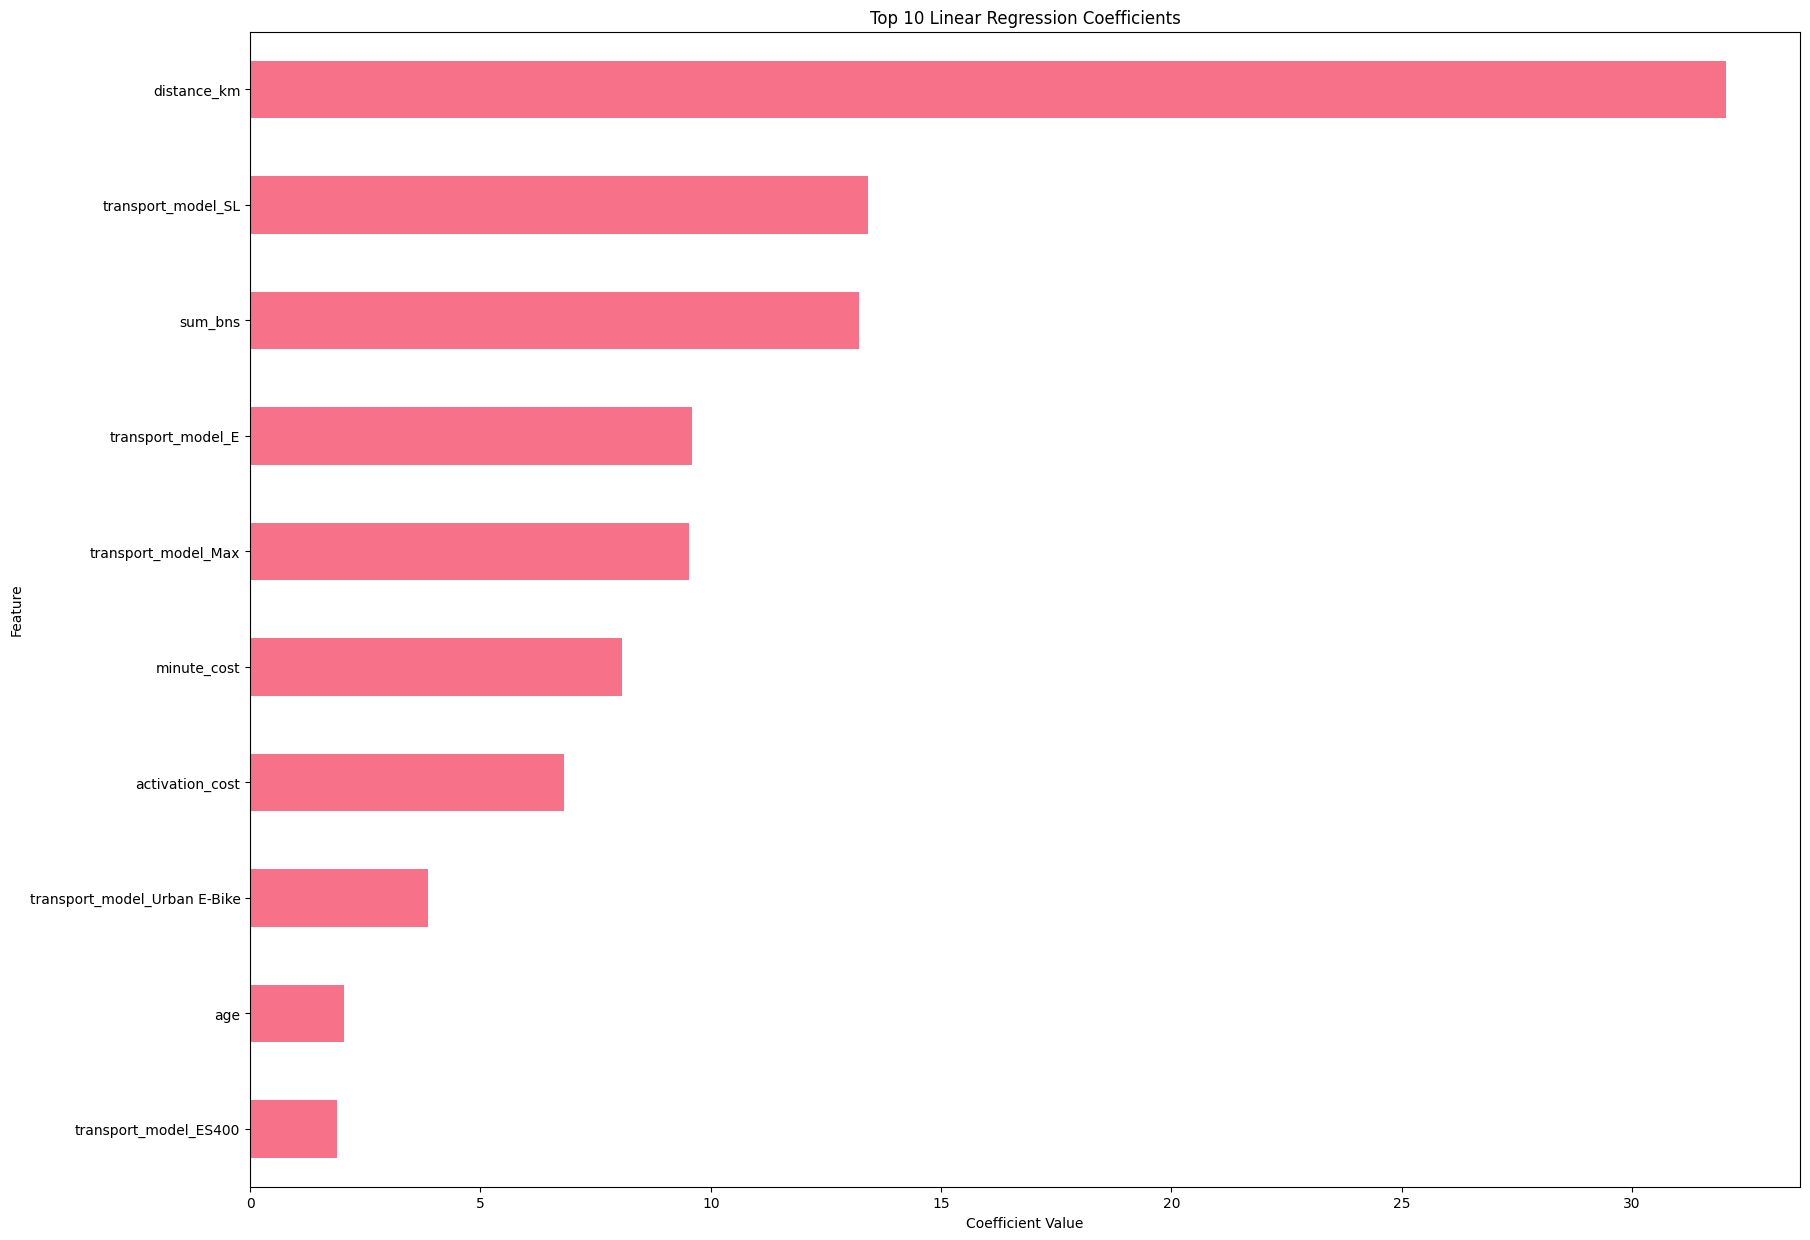

In [25]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def preprocess_and_regression(df):
    target = 'price'
    features = [
        'age', 'minute_cost', 'activation_cost', 'hold_amount',
        'distance_km', 'book_time_zone_cd', 'sum_bns'
    ]
    categorical_cols = [
        'gender_cd', 'education_level_cd', 'marital_status_cd',
        'lvn_state_nm', 'transport_model'
    ]
    # One-hot encode categorical features
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    all_feature_cols = features + [
        col for col in df_encoded.columns
        if any(f"{c}_" in col for c in categorical_cols)
    ]

    std = StandardScaler()

    X = df_encoded[all_feature_cols]
    y = df_encoded[target]

    X = pd.DataFrame(std.fit_transform(X), columns=X.columns)

    # Fill missing values with median
    X = X.fillna(X.median(numeric_only=True))
    y = y.fillna(y.median())

    # Fit linear regression
    reg = LinearRegression()
    reg.fit(X, y)
    coefs = pd.Series(reg.coef_, index=X.columns)

    # Get top 10 absolute dependencies
    top10 = coefs.abs().sort_values(ascending=False).head(10).index
    abs(coefs).loc[top10].sort_values().plot(kind='barh')
    plt.title("Top 10 Linear Regression Coefficients")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.show()

preprocess_and_regression(df)


Замечу что наибольшее линейное влияние на цену платит человек оказывает - дистанция. Что логично.